In [181]:
import pandas as pd
import numpy as np
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round1'

In [182]:
df1 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-2.csv', delimiter = ";")
df2 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_-1.csv', delimiter = ";")
df3 = pd.read_csv('../../../data/round-1-island-data-bottle/prices_round_1_day_0.csv', delimiter = ";")

In [184]:
df = pd.concat([df1, df2, df3])

In [185]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df

In [186]:
df = orderbook_preprocess(df)

In [187]:
def extract_product_df(df, symbol: str):
    df_product = df[df['product'] == symbol]
    #重新设置索引
    return df_product

In [188]:
df_ink = extract_product_df(df, 'KELP')
df_resin = extract_product_df(df, 'RAINFOREST_RESIN')
df_ink = extract_product_df(df, 'SQUID_INK')

In [189]:
from scipy.stats import kurtosis
def generate_features(df):
        df = df.copy()
        df['mid_price'] = (df['ask_price_1'] + df['bid_price_1']) / 2
        df['spread'] = df['ask_price_1'] - df['bid_price_1']
        df['vwap'] = (
            df['ask_price_1'] * df['ask_volume_1'] +
            df['ask_price_2'] * df['ask_volume_2'] +
            df['ask_price_3'] * df['ask_volume_3'] +
            df['bid_price_1'] * df['bid_volume_1'] +
            df['bid_price_2'] * df['bid_volume_2'] +
            df['bid_price_3'] * df['bid_volume_3']
        ) / (
            df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] +
            df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        )

        df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
        df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
        df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
        df['log_return_5'] = np.log(df['mid_price']).diff(-5)
        df['log_return_1'] = np.log(df['mid_price']).diff(-1)
        df['vol_10'] = df['mid_price'].rolling(10).std()
        df['kurt_50'] = df['log_return_5'].rolling(50).apply(lambda x: kurtosis(x, fisher=False), raw=True)
        df['mid_mean_20'] = df['mid_price'].rolling(20).mean()
        df['mid_reversion_gap'] = df['mid_price'] - df['mid_mean_20']
        df['orderbook_imbalance'] = (df['bid_volume'] - df['ask_volume']) / (df['bid_volume'] + df['ask_volume'] )
        df['depth_ratio'] = df['bid_volume_1'] / (df['bid_volume'])
        df['relative_spread'] = df['spread'] / (df['mid_price'])
        df['imbalance_diff'] = df['orderbook_imbalance'].diff(-5)
        df['vol_diff'] = df['vol_10'].diff(-5)
        df['spread_change'] = df['spread'].diff(-5)
        df['return_vol_ratio'] = df['log_return_1'].abs() / (df['vol_10'] )

        #人工构造alpha
        df['alpha1'] = df['log_return_1'] - df['log_return_5']
        df['alpha2'] = df['mid_reversion_gap'] * df['orderbook_imbalance']
        df['alpha3'] = df['spread'] * df['depth_ratio']
        df['alpha4'] = df['vwap'] - df['mid_price']
        df['alpha5'] = df['relative_spread'] * df['return_vol_ratio']
        return df

def get_return(df):
    df = df.copy()
    df['log_return'] = np.log(df['mid_price']).diff(5)
    #三分类构造target
    threshold = 0.01
    return_std = df['log_return'].std()
    df.loc[df['log_return'] < -return_std * 0.1, 'target'] = 0
    df.loc[abs(df['log_return']) < return_std * 0.1, 'target'] = 1
    df.loc[df['log_return'] > return_std * 0.1, 'target'] = 2

    return df


In [190]:
def preprocess_price(df):
    df = df.copy()
    df = generate_features(df)
    df= get_return(df)
    df.dropna(inplace=True)
    return df

In [191]:
df_ink = preprocess_price(df_ink)
df_resin = preprocess_price(df_resin)
df_ink = preprocess_price(df_ink)

In [ ]:
df_ink.to_csv('../../../data/round1/round1_kelp.csv')
df_resin.to_csv('../../../data/round1/round1_resin.csv')
df_ink.to_csv('../../../data/round1/round1_ink.csv')


In [76]:
#研究因子和log_return5的相关性
def ic_analysis(df):
    feature_cols = [col for col in df.columns if col not in ['day', 'timestamp', 'product', 'profit_and_loss', 'log_return5']]

    df = df.loc[:,['log_return5'] + feature_cols]

    #对所有因子计算ic并且排序
    ic_dict = {}
    selected_cols = []
    for col in feature_cols:
        ic = df.loc[:,['log_return5',col]].corr().iloc[0,1]
        if abs(ic) > 0.5:
            selected_cols.append(col)
        ic_dict[col] = ic
    #排序
    ic_dict = dict(sorted(ic_dict.items(), key=lambda item: abs(item[1]), reverse=True))
    return ic_dict, selected_cols


In [ ]:
kelp_dict, kelp_cols = ic_analysis(df_ink)
resin_dict, resin_cols = ic_analysis(df_resin)
ink_dict, ink_cols = ic_analysis(df_ink)


In [56]:
print(f"kelp_cols: {kelp_cols}, resin_cols: {resin_cols}, ink_cols: {ink_cols}")

kelp_cols: ['mid_reversion_gap', 'alpha4'], resin_cols: ['bid_price_1', 'ask_price_1', 'mid_price', 'mid_reversion_gap', 'alpha4'], ink_cols: ['mid_reversion_gap']


In [113]:
print(kelp_dict)

{'mid_reversion_gap': 0.7198670984550897, 'alpha4': -0.6153677796279612, 'log_return_1': 0.44433709754313455, 'ask_price_2': -0.4292536286682099, 'log_return_5': 0.41119454737019817, 'ask_volume_1': 0.4068216117822813, 'depth_ratio': -0.40538585579668124, 'bid_price_2': 0.40310559362403114, 'ask_volume_2': -0.3855321799229783, 'bid_volume_1': -0.3762193092788666, 'bid_volume_2': 0.37044993533517856, 'orderbook_imbalance': 0.37009000571045714, 'ask_bid_ratio': -0.37009000571045714, 'imbalance_diff': 0.2628963658640888, 'ask_volume': -0.1906029000487127, 'ask_price_3': -0.18217065331203539, 'ask_volume_3': -0.17771546055451964, 'alpha3': -0.17034600638224928, 'bid_price_3': 0.16477967476059954, 'bid_volume_3': 0.1609963973260148, 'bid_volume': 0.1381286237373546, 'alpha2': -0.07297805327259428, 'spread': 0.04757651609684951, 'relative_spread': 0.047284623551877396, 'spread_change': 0.0373279665964311, 'ask_price_1': 0.036984140466312265, 'mid_price': 0.03512608383750265, 'bid_price_1': 0

In [114]:
print(resin_dict)

{'mid_reversion_gap': 0.7243227453705755, 'mid_price': 0.7059024274323772, 'alpha4': -0.6499918618112703, 'ask_price_1': 0.5471163881192728, 'bid_price_1': 0.5399255928924644, 'log_return_5': 0.4987491715085987, 'log_return_1': 0.4984050104031618, 'ask_price_3': -0.386900183111169, 'bid_price_3': 0.375274690835787, 'ask_volume_3': -0.34641637853884777, 'bid_volume_3': 0.33850615968844583, 'vwap': 0.19990857682501068, 'ask_price_2': -0.1991627936408248, 'bid_price_2': 0.19255264979429892, 'best_ask': 0.16429986250033488, 'depth_ratio': -0.15795333074398615, 'ask_volume_1': 0.15470846259685306, 'bid_volume_1': -0.15150125997993466, 'best_bid': 0.14793203500441848, 'ask_volume': -0.1045876259520289, 'bid_volume': 0.09847051145738299, 'ask_volume_2': 0.09311976141415584, 'bid_volume_2': -0.09120836817335172, 'orderbook_imbalance': 0.08490211283806412, 'ask_bid_ratio': -0.08490211283806412, 'alpha3': -0.07847911070867189, 'imbalance_diff': 0.05646102807105575, 'alpha2': 0.012941865685126433

In [115]:
print(ink_dict)

{'mid_reversion_gap': 0.758864518682825, 'alpha4': -0.15352511774725638, 'ask_price_2': -0.10697742812683558, 'ask_volume_1': 0.10244038142681106, 'bid_price_2': 0.10202577526944112, 'depth_ratio': -0.10155349003391598, 'orderbook_imbalance': 0.09716871011036501, 'ask_bid_ratio': -0.09716871011036501, 'ask_volume_2': -0.09674808207462464, 'log_return_1': 0.09395095050546634, 'bid_volume_1': -0.09268467545469393, 'bid_volume_2': 0.09158515669048142, 'imbalance_diff': 0.07245122565643841, 'log_return_5': 0.05268853038580177, 'bid_price_3': 0.05170092943199714, 'bid_volume_3': 0.05077540328120849, 'ask_price_3': -0.04566906860092077, 'ask_volume': -0.0453172545675617, 'ask_volume_3': -0.04480665250918096, 'bid_volume': 0.04335435673026305, 'alpha3': -0.04278513136859616, 'vol_diff': 0.041033885867204675, 'ask_price_1': 0.031870162596676965, 'mid_price': 0.03179499444851422, 'bid_price_1': 0.03171847670823958, 'best_bid': 0.030600971259803905, 'vwap': 0.03058700688138409, 'best_ask': 0.030

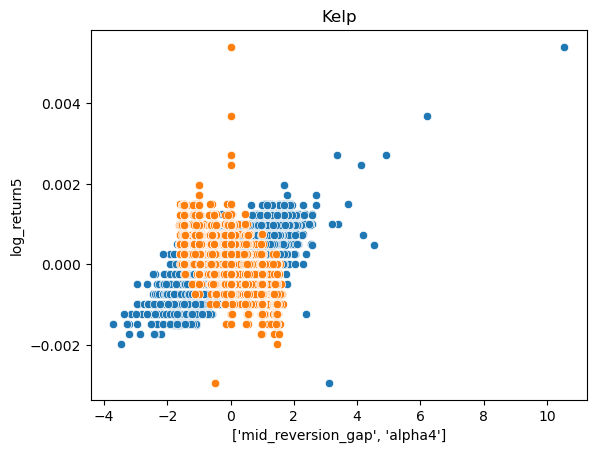

In [ ]:
#研究因子和log_return5的关系
import matplotlib.pyplot as plt
import seaborn as sns

for col in kelp_cols:
    sns.scatterplot(x=df_ink[col], y=df_ink['log_return5'])
    plt.xlabel(kelp_cols)
    plt.ylabel('log_return5')
    plt.title('Kelp')

plt.show()

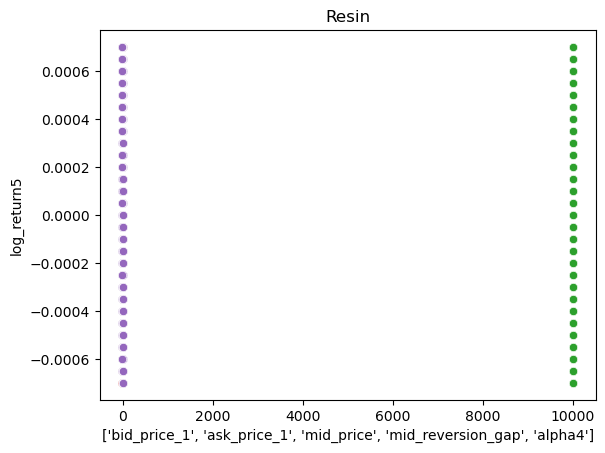

In [65]:
for col in resin_cols:
    sns.scatterplot(x=df_resin[col], y=df_resin['log_return5'])
    plt.xlabel(resin_cols)
    plt.ylabel('log_return5')
    plt.title('Resin')
plt.show()

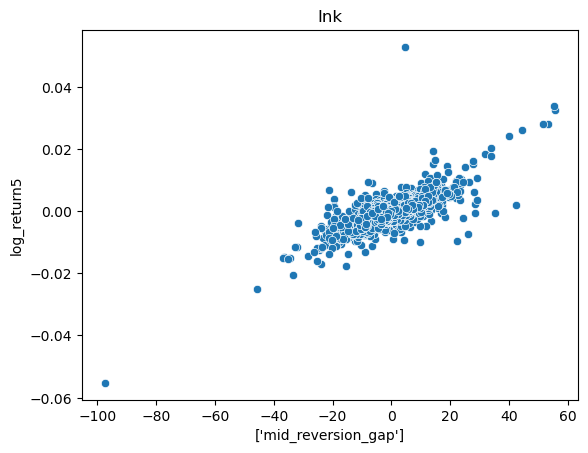

In [66]:
for col in ink_cols:
    sns.scatterplot(x=df_ink[col], y=df_ink['log_return5'])
    plt.xlabel(ink_cols)
    plt.ylabel('log_return5')
    plt.title('Ink')

<Axes: xlabel='mid_price', ylabel='Count'>

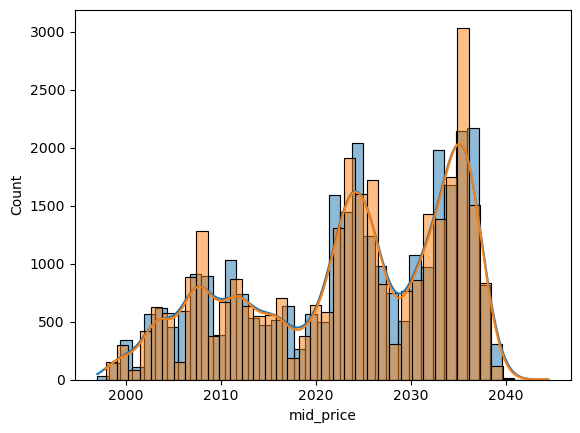

In [ ]:
#可视化
import matplotlib.pyplot as plt
import seaborn as sns

#基本因子分布
columns = ['mid_price', 'vwap', 'spread', 'orderbook_imbalance', 'ask_bid_ratio']

sns.histplot(df_ink['mid_price'], kde=True)
sns.histplot(df_ink['vwap'], kde = True)


count    30000.000000
mean         0.000060
std          0.061267
min         -0.636364
25%          0.000000
50%          0.000000
75%          0.015385
max          0.621622
Name: orderbook_imbalance, dtype: float64
Non zero ratio of orderbook imbalacne: 0.4992


<Axes: xlabel='orderbook_imbalance', ylabel='Count'>

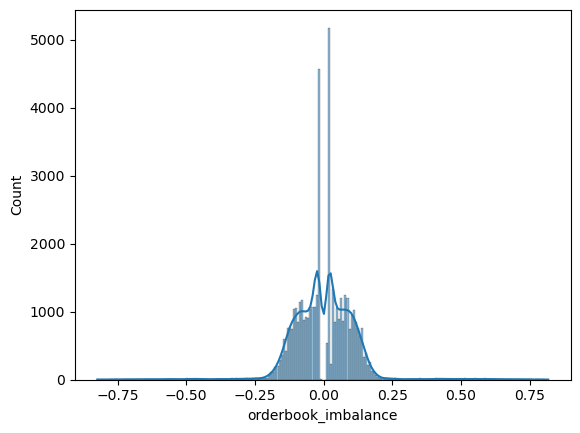

In [ ]:
print(df_ink['orderbook_imbalance'].describe())

#计算0的个数和非0个数
zero_count = df_ink['orderbook_imbalance'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_ink)
print(f'Non zero ratio of orderbook imbalance: {non_zero_ratio}')

df_ink_filterd = df[df['orderbook_imbalance']!= 0]
sns.histplot(df_ink_filterd['orderbook_imbalance'], kde = True)


count    30000.000000
mean        -0.000060
std          0.061267
min         -0.621622
25%         -0.015385
50%          0.000000
75%          0.000000
max          0.636364
Name: ask_bid_ratio, dtype: float64
Non zero ratio of ask bid ratio: 0.4992


<Axes: xlabel='ask_bid_ratio', ylabel='Count'>

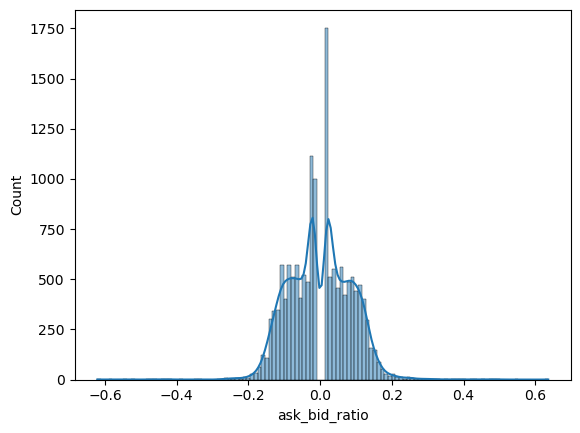

In [ ]:
print(df_ink['ask_bid_ratio'].describe())
#计算0的个数和非0个数
zero_count = df_ink['ask_bid_ratio'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_ink)
print(f'Non zero ratio of ask bid ratio: {non_zero_ratio}')

df_ink_filterd = df_ink[df_ink['ask_bid_ratio'] != 0]
sns.histplot(df_ink_filterd['ask_bid_ratio'], kde = True)

In [152]:
import math
def fractional_derivative(ts, alpha, n_terms=10):
    """
    计算时间序列 ts 的分数阶导数
    参数:
        ts: 时间序列
        alpha: 阶数
        n_terms: 历史项的数量，控制内存长短

    返回:
        分数阶导数序列（长度与 ts 相同，前面一些值为 nan）
    """

    def binomial_coeff(a, k):
        return math.gamma(a + 1) / (math.gamma(k + 1) * math.gamma(a - k + 1))

    ts = np.asarray(ts)
    result = np.full_like(ts, np.nan, dtype=np.float64)

    for t in range(n_terms, len(ts)):
        val = 0.0
        for k in range(n_terms):
            coeff = (-1) ** k * binomial_coeff(alpha, k)
            val += coeff * ts[t - k]
        result[t] = val
    return result

def rolling_window(ts, window_length: int):
    ts_diff = ts.diff(window_length)
    ts_vol = ts.rolling(window_length).std()
    ts_mean = ts.rolling(window_length).mean()
    ts_zscore = (ts - ts_mean) / ts_vol
    return ts_diff, ts_vol, ts_mean, ts_zscore


In [161]:
from scipy.stats import kurtosis

def get_return(df):
    df = df.copy()
    df['mid_price_diff_5'] = df['mid_price'] - df['mid_price'].shift(5)
    df['log_return_5'] = np.log(df['mid_price']).diff(5)
    df.dropna(inplace=True)
    k = kurtosis(df['log_return_5'])
    print("Kurtosis of log_return_5: ", k)
    return df

<Axes: xlabel='mid_price_diff', ylabel='Count'>

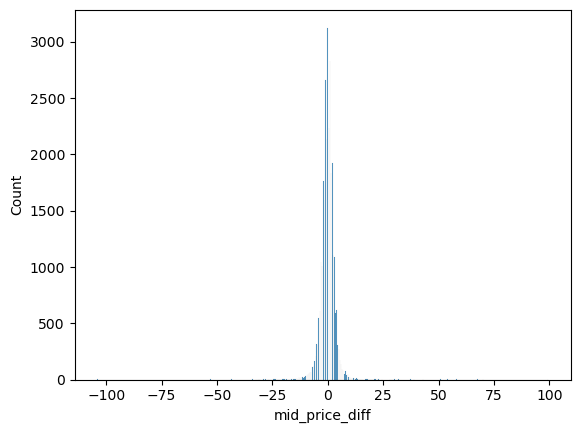

In [ ]:
sns.histplot(df_ink['mid_price_diff'])

In [171]:
def IC_IR(df, factor_column: str, return_column: str, risk_free_rate: float):
    """
    Calculate the Information Coefficient (IC) and Implied Risk-Free Rate (IRR) of a factor using the CAPM model.
    :param df: DataFrame with columns for the factor, return, and market return.
    :param factor_column: Name of the column containing the factor values.
    :param return_column: Name of the column containing the return values.
    :param risk_free_rate: Risk-free rate used in the CAPM model.
    :return: Tuple of the IC and IRR values.
    """
    # Calculate the market return
    market_return = df[return_column].mean()
    # Calculate the CAPM beta
    beta = (df[return_column] - risk_free_rate - df[factor_column] * market_return) / (df[factor_column] ** 2)

    # Calculate the CAPM alpha
    alpha = market_return - risk_free_rate - beta * df[factor_column]

    # Calculate the Information Coefficient (IC)
    ic = (beta ** 2) / (1 - beta ** 2)

    # Calculate the Implied Risk-Free Rate (IRR)
    irr = (1 + alpha) / (1 + beta)
    return ic, irr


In [176]:
df_ink['kurt_50'] = df_ink['log_return_5'].rolling(50).apply(kurtosis)
df_ink.dropna(inplace=True)
ic, irr = IC_IR(df_ink, 'log_return_5', 'kurt_50', 0)
#print(ic, irr)


In [ ]:
print(ic.describe())
sns.histplot(ic, kde=False)

count    26778.000000
mean        -1.000000
std          0.000036
min         -1.005501
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
dtype: float64


In [ ]:
def calculate_factors(df):
    """
    计算因子：
    订单簿因子：orderbook_imbalance, ask_bid_ratio（已实现）
    基本因子：对数收益率（5）， 波动率（10）
    肥尾因子：kurt(50)
    衍生因子：上述的1阶差分和1/2阶差分
    """
    df['log_return5'] = np.log(df['mid_price']).diff(5)
    df['vol10'] = df['mid_price'].rolling(10).std()
    df['kurt50'] = df['log_return_5'].rolling(10).kurt()
    df['orderbook_imbalance_5_1/2'] = fractional_derivative(df['orderbook_imbalance'], 1/2, 5)
    df['orderbook_imbalance_5_1'] = fractional_derivative(df['orderbook_imbalance'], 1, 5)
    df['ask_bid_ratio_5_1/2'] = fractional_derivative(df['ask_bid_ratio'], 1/2, 5)
    df['ask_bid_ratio_5_1'] = fractional_derivative(df['ask_bid_ratio'], 1, 5)
    df['vol10_5_1/2'] = fractional_derivative(df['vol10'], 0.5, 5)
    df['vol10_5_1'] = fractional_derivative(df['vol10'], 1, 5)
    df['kurt50_5_1/2'] = fractional_derivative(df['kurt50'], 0.5, 5)
    df['kurt_50_1'] = fractional_derivative(df['kurt50'], 1, 5)
    return df

In [192]:
df_ink0 = df_ink[df_ink['day'] == -2]
df_ink1 = df_ink[df_ink['day'] == -1]
df_ink2 = df_ink[df_ink['day'] == 0]


In [ ]:
#FFT

def fft(prices):
    fft_result = np.fft.fft(prices)
    frequencies = np.fft.fftfreq(len(prices))
    amplitude = np.abs(fft_result)
    return frequencies, amplitude

frequencies, amplitude = fft(df_ink0['mid_price'])

threshold = 0
amplitude = np.where(amplitude > threshold, amplitude, 0)

# 绘制频谱图
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude)
plt.title('Frequency Domain')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


   



In [129]:
from scipy.signal import find_peaks

def extract_peaks(frequencies, amplitude, height_threshold=0.1, distance_threshold=10):
    """
    提取频谱图中的所有显著峰。
    height_threshold: 用于过滤幅度较小的峰
    distance_threshold: 用于设置峰与峰之间的最小距离
    """
    # 找到所有峰
    peaks, properties = find_peaks(amplitude, height=height_threshold, distance=distance_threshold)

    # 提取峰对应的频率和幅度
    peak_frequencies = frequencies[peaks]
    peak_amplitudes = amplitude[peaks]

    return peak_frequencies, peak_amplitudes, properties


# 聚合相邻的峰
def aggregate_peaks(frequencies, amplitude, distance_threshold=10, height_threshold=0.1):
    """
    将相邻的频率成分合并为一个峰，避免识别多个小峰。
    """
    peaks, _ = find_peaks(amplitude, height=height_threshold)
    
    aggregated_peaks = []
    aggregated_amplitudes = []
    current_peak = None
    current_amplitude = 0
    
    # 遍历所有峰，将相邻的峰聚合
    for i in range(len(peaks)):
        if current_peak is None:
            current_peak = peaks[i]
            current_amplitude = amplitude[current_peak]
        else:
            # 如果相邻的两个峰之间的距离小于阈值，则将它们聚合
            if np.abs(frequencies[peaks[i]] - frequencies[current_peak]) < distance_threshold:
                current_peak = peaks[i]
                current_amplitude = max(current_amplitude, amplitude[current_peak])
            else:
                aggregated_peaks.append(frequencies[current_peak])
                aggregated_amplitudes.append(current_amplitude)
                current_peak = peaks[i]
                current_amplitude = amplitude[current_peak]
    
    # 添加最后一个峰
    if current_peak is not None:
        aggregated_peaks.append(frequencies[current_peak])
        aggregated_amplitudes.append(current_amplitude)
    
    return np.array(aggregated_peaks), np.array(aggregated_amplitudes)


In [ ]:
distance_threshold = 0.05  # 设置峰之间的最小频率间隔
height_threshold = 0.1  # 设置峰的最小幅度
aggregated_peaks, aggregated_amplitudes = aggregate_peaks(frequencies, amplitude, distance_threshold, height_threshold)

# 可视化聚合后的频谱图
plt.figure(figsize=(12, 6))
plt.plot(frequencies, amplitude, label="Amplitude Spectrum")
plt.scatter(aggregated_peaks, aggregated_amplitudes, color='red', zorder=5, label='Aggregated Peaks')
plt.title('Frequency Domain with Aggregated Peaks')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

# 打印出聚合峰的频率和幅度
for f, a in zip(aggregated_peaks, aggregated_amplitudes):
    print(f"Aggregated Peak at frequency {f:.4f} with amplitude {a:.4f}")

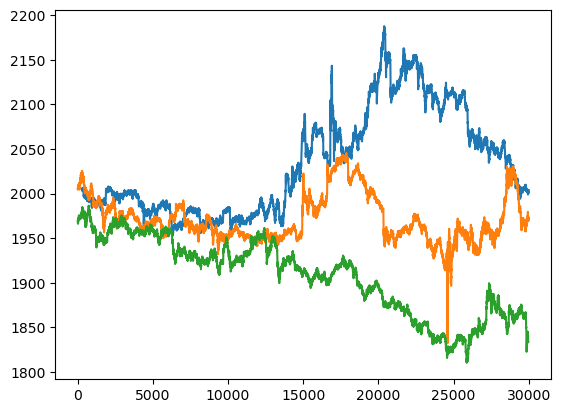

In [193]:
plt.plot(df_ink0['mid_price'])
plt.plot(df_ink1['mid_price'])
plt.plot(df_ink2['mid_price'])

In [194]:
diff_ink01 = df_ink0['mid_price'] - df_ink1['mid_price']
diff_ink02 = df_ink0['mid_price'] - df_ink2['mid_price']
diff_ink12 = df_ink1['mid_price'] - df_ink2['mid_price']

In [143]:
print(df_ink.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'best_bid', 'best_ask', 'spread', 'vwap', 'orderbook_imbalance',
       'ask_volume', 'bid_volume', 'ask_bid_ratio', 'log_return_5',
       'log_return_1', 'vol_10', 'kurt_50', 'mid_mean_20', 'mid_reversion_gap',
       'depth_ratio', 'relative_spread', 'imbalance_diff', 'vol_diff',
       'spread_change', 'return_vol_ratio', 'alpha1', 'alpha2', 'alpha3',
       'alpha4', 'alpha5', 'log_return5', 'log_return', 'target'],
      dtype='object')


In [144]:
df_ink['mid_price_diff'] = df_ink['mid_price'] - df_ink['mid_price'].shift(-1)

In [207]:
%ls ../../../data/2023/

prices_round_1_day_-1.csv     trades_round_2_day_-1_nn.csv
prices_round_1_day_-2.csv     trades_round_2_day_-1_wn.csv
prices_round_1_day_0.csv      trades_round_2_day_0_nn.csv
prices_round_2_day_-1.csv     trades_round_2_day_0_wn.csv
prices_round_2_day_0.csv      trades_round_2_day_1_nn.csv
prices_round_2_day_1.csv      trades_round_2_day_1_wn.csv
prices_round_3_day_0.csv      trades_round_3_day_0_nn.csv
prices_round_3_day_1.csv      trades_round_3_day_0_wn.csv
prices_round_3_day_2.csv      trades_round_3_day_1_nn.csv
prices_round_4_day_1.csv      trades_round_3_day_1_wn.csv
prices_round_4_day_2.csv      trades_round_3_day_2_nn.csv
prices_round_4_day_3.csv      trades_round_3_day_2_wn.csv
trades_round_1_day_-1_nn.csv  trades_round_4_day_1_nn.csv
trades_round_1_day_-1_wn.csv  trades_round_4_day_1_wn.csv
trades_round_1_day_-2_nn.csv  trades_round_4_day_2_nn.csv
trades_round_1_day_-2_wn.csv  trades_round_4_day_2_wn.csv
trades_round_1_day_0_nn.csv   trades_round_4_day_3_nn.csv
trades_round

In [ ]:
df11 = pd.read_csv('../../../data/2023/prices_round_1_day_-2.csv')
df12 = pd.read_csv('../../../data/2023/prices_round_1_day_-1.csv')
df13 = pd.read_csv('../../../data/2023/prices_round_1_day_0.csv')
df21 = pd.read_csv('../../../data/2023/prices_round_2_day_-1.csv')
df22 = pd.read_csv('../../../data/2023/prices_round_2_day_0.csv')
df23 = pd.read_csv('../../../data/2023/prices_round_2_day_1.csv')
df31 = pd.read_csv('../../../data/2023/prices_round_3_day_0.csv')
df32 = pd.read_csv('../../../data/2023/prices_round_3_day_1.csv')
df33 = pd.read_csv('../../../data/2023/prices_round_3_day_2.csv')
df41 = pd.read_csv('../../../data/2023/prices_round_4_day_1.csv')
df42 = pd.read_csv('../../../data/2023/prices_round_4_day_2.csv')
df43 = pd.read_csv('../../../data/2023/prices_round_4_day_3.csv')

df1 = pd.concat([df11, df12, df13])
df2 = pd.concat([df21, df22, df23])
df3 = pd.concat([df31, df32, df33])
df4 = pd.concat([df41, df42, df43])

product1 = list(df1['product'].unique())
product2 = list(df2['product'].unique())
product3 = list(df3['product'].unique())
product4 = list(df4['product'].unique())

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/2023/prices_round_2_day_-0.csv'

In [204]:

product_dfs = {}
for df, products in [(df1, product1), (df2, product2), (df3, product3), (df4, product4)]:
    for product in products:
        product_dfs[product] = df[df['product'] == product]



NameError: name 'product2' is not defined

['RAINFOREST_RESIN', 'KELP', 'SQUID_INK']